In [2]:
import sys
import gizmo_analysis as gizmo
import utilities as ut
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
simulation_directory = '/Users/rorik/reu/m12i'

In [4]:
# Read star particles at z = 0, store as a python dictionary

part = gizmo.io.Read.read_snapshots(['star'], 'redshift', 0, simulation_directory, 
                                    assign_hosts_rotation=True, assign_formation_coordinates=True)
# Alternately, read all particle species at z = 0

# part = gizmo.io.Read.read_snapshots('all', 'redshift', 0, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  Users/rorik/reu/m12i/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/rorik/reu/m12i/output\snapdir_600\snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['star']

* reading particles from:
    output\snapdir_600\snapshot_600.0.hdf5
    output\snapdir_600\snapshot_600.1.hdf5
    output\snapdir_600\snapshot_600.2.hdf5
    output\snapdir_600\snapshot_600.3.hdf5

* reading cosmological parameters from:  Users/rorik/reu/m12i\initial_condition\ic_agora_m12i.conf

* checking sanity of particle properties


# in gizmo_analysis.gizmo_track.ParticleCoordinate():
  read 1 host

In [5]:
part['star'].keys()

dict_keys(['position', 'mass', 'massfraction', 'id.child', 'id.generation', 'id', 'potential', 'form.scalefactor', 'velocity', 'form.host.distance', 'form.host.velocity'])

## Derived properties

You can use __.prop('*property_name*')__ to derive other (more useful) quantities.

Some properties that you may want include:
-  'host.distance' : 3D distance of particles from the center of the galaxy in x,y,z grid [kpc physical]
-  'host.distance.total' : Total (1D) distance from the center of the galaxy [kpc physical]
-  'host.velocity' : 3D velocity of particles with respect to the center of the galaxy in x,y,z grid [km/s]
-  'host.velocity.total' : Total (scalar) velocity [km/s]

Star particles also have:
-  'form.time' : Age of the Universe when the star particle formed [Gyr]
-  'age' : Age of the star particle at the current snapshot [Gyr]

Gas particles also have:
-  'number.density' : [hydrogen atoms / cm^3]

See the documentation in the gizmo_io.py file for all options of derived quantities.

Here are a few examples of how to look at properties of star particles.

In [77]:
# # masking

# # stars formed within 30 kpc comoving of the galaxy
# form_distances = part['star'].prop('host.form.distance.total')
# form_scalefactors = part['star'].prop('form.scalefactor')
# form_filter = (form_distances / form_scalefactors) < 30

# # |z| < 3kpc
# z_filter = abs(part['star'].prop('host.distance.principal.cyl')[::,2]) < 3

# # r < 15 kpc
# r_filter = part['star'].prop('host.distance.principal.cyl')[::,0] < 15
# masks = z_filter & r_filter & form_filter

In [6]:
# filtering with indices
inds = ut.array.get_indices(part['star'].prop('host.form.distance.total')/part['star'].prop('form.scalefactor'), [0,30])
inds = ut.array.get_indices(part['star'].prop('host.distance.principal.cyl')[::,2], [-3,3], inds)
inds = ut.array.get_indices(part['star'].prop('host.distance.principal.cyl')[::,0], [0,15], inds)
# inds = ut.array.get_indices(particles['star']['age'], [0,8])

# inds = ut.array.get_indices(particles['star']['distance'], [0,200], inds)

In [7]:
# position of stars in cylindrical coordinates
# First value is along the major axes (R, positive definite) [kpc physical]
# Second value is angle (phi, 0 to 2 * pi) [radian]
# Third value is vertical height wrt the disk (Z, signed) [kpc physical]

ps = part['star'].prop('host.distance.principal.cyl')[inds] # in kpc

# Compute 3-D velocity in cylindrical coordinates
# First value is along the major axes
# Secod value is azimuthal velocity in the plane of the disk 
# (the disk is oriented) so the mean v_phi should be positive
# Third value is vertical velocity wrt the disk (signed)

vs = part['star'].prop('host.velocity.principal.cyl')[inds] # in km/s

age = part['star'].prop('age')[inds] # in gyr

In [8]:
# formation coordinates/velocity of stars in cylindrical coordinates
ps_form = part['star'].prop('form.host.distance.principal.cyl')[inds]
vs_form = part['star'].prop('form.host.velocity.principal.cyl')[inds]

In [9]:
R = ps[::, 0]
v_phi = vs[::, 1]
v_R = vs[::, 0]
v_z = vs[::, 2]

R_form = ps_form[::, 0]
v_phi_form = vs_form[::, 1]
v_R_form = vs_form[::, 0]
v_z_form = vs_form[::, 2]

In [10]:
from scipy.stats import binned_statistic

def bin_helper(x, y, bins, stat='mean'):

    stat, edges, _ = binned_statistic(x, y, statistic=stat, bins=14)
    std, edges, _ = binned_statistic(x, y, statistic='std', bins=14)
    bins = edges[:-1]
    
    return stat, std, bins

# ut.bin.get_statistics_of_array()

In [11]:
def plot_helper(x, y, label, c='r', stat='mean', ax=None, scatter=True, grid=True):
    if ax==None:
        ax = plt.gca()
    if scatter:
        ax.scatter(x, y, s=1, alpha=0.1)
    stat_y, std, bins = bin_helper(x, y, 14, stat=stat)
    
    ax.plot(bins, stat_y, 'o-', c=c, label=label)
    ax.fill_between(bins, stat_y-std, stat_y+std, color=c, alpha=0.5)
    ax.legend(loc='upper right')
    if grid:
        ax.grid()
    return ax

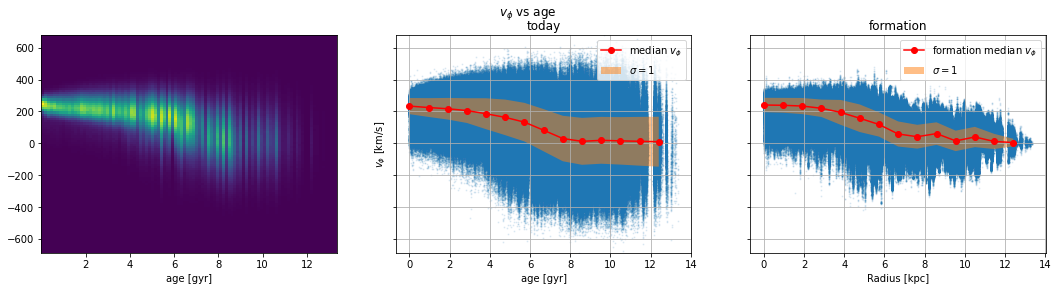

In [97]:
median_v_phi, std_v_phi, v_phi_bins = bin_helper(age, v_phi, 14, stat='median')

fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True, gridspec_kw={'width_ratios': [1, 1, 1]})
fig.suptitle('$v_{\phi}$ vs age')

H, xedges, yedges = np.histogram2d(age, v_phi, bins=100)
H = H.T
X, Y = np.meshgrid(xedges, yedges)
axs[0].pcolormesh(X, Y, H)
axs[0].set(xlabel = 'age [gyr]');

axs[1] = plot_helper(age, v_phi, 'median $v_{\phi}$', ax=axs[1], stat='median')
axs[1].set(xlabel = 'age [gyr]', ylabel = '$v_{\phi}$ [km/s]', title='today')

axs[2] = plot_helper(age, v_phi_form, 'formation median $v_{\phi}$', ax=axs[2], stat='median')
axs[2].set(title='formation', xlabel = 'Radius [kpc]');

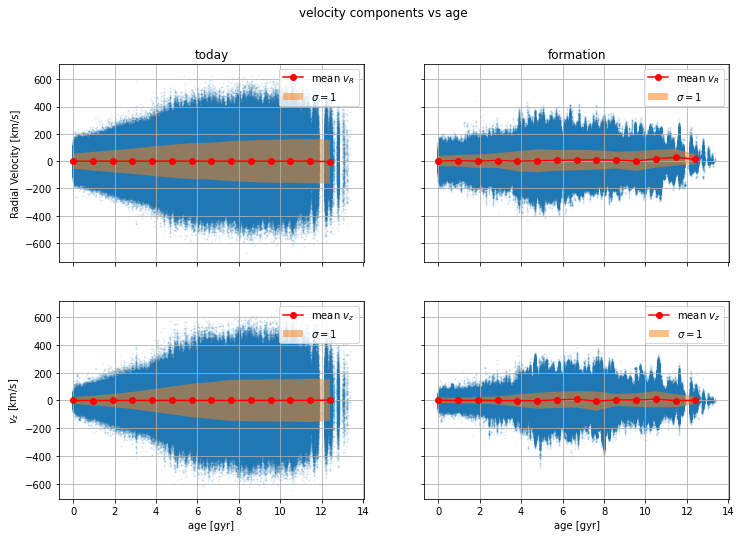

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey='row', sharex=True)
fig.suptitle('velocity components vs age')

axs[0,0] = plot_helper(age, v_R, 'mean $v_R$', ax=axs[0,0])
axs[0,0].set(ylabel = 'Radial Velocity [km/s]', title='today')

axs[0,1] = plot_helper(age, v_R_form, 'mean $v_R$', ax=axs[0,1])
axs[0,1].set(title='formation');

axs[1,0] = plot_helper(age, v_z, 'mean $v_z$', ax=axs[1,0])
axs[1,0].set(xlabel = 'age [gyr]', ylabel = '$v_z$ [km/s]')

axs[1,1] = plot_helper(age, v_z_form, 'mean $v_z$', ax=axs[1,1])
axs[1,1].set(xlabel = 'age [gyr]');

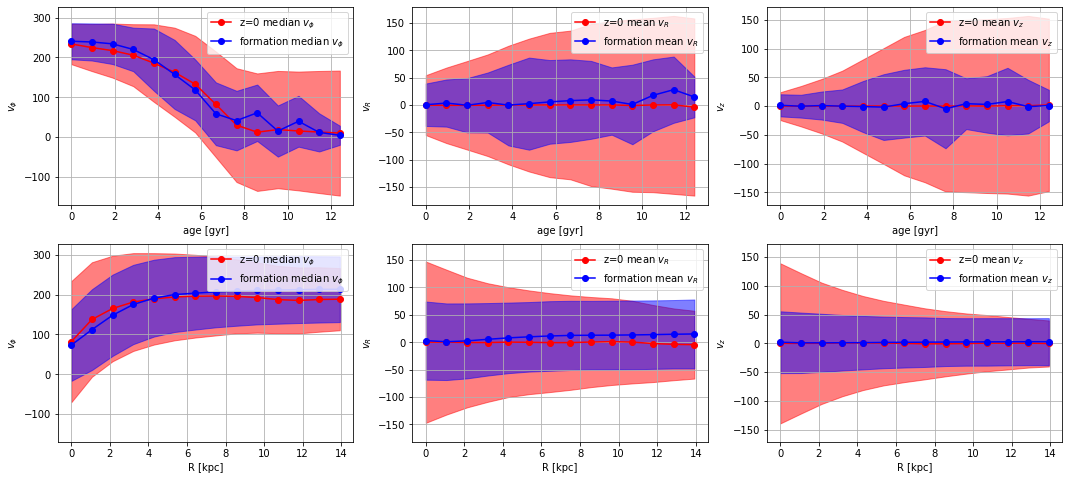

In [193]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharey='col', sharex='row')

axs[0,0] = plot_helper(age, v_phi, 'z=0 median $v_{\phi}$', ax=axs[0,0], stat='median', scatter=False, c='r')
axs[0,0] = plot_helper(age, v_phi_form, 'formation median $v_{\phi}$', ax=axs[0,0], stat='median', scatter=False, c='b', grid=False)
axs[0,0].set(xlabel = 'age [gyr]', ylabel='$v_{\phi}$')

axs[0,1] = plot_helper(age, v_R, 'z=0 mean $v_R$', ax=axs[0,1], scatter=False, c='r')
axs[0,1] = plot_helper(age, v_R_form, 'formation mean $v_R$', ax=axs[0,1], scatter=False, c='b', grid=False)
axs[0,1].set(xlabel = 'age [gyr]', ylabel='$v_R$')

axs[0,2] = plot_helper(age, v_z, 'z=0 mean $v_z$', ax=axs[0,2], scatter=False, c='r')
axs[0,2] = plot_helper(age, v_z_form, 'formation mean $v_z$', ax=axs[0,2], scatter=False, c='b', grid=False)
axs[0,2].set(xlabel = 'age [gyr]', ylabel='$v_z$')

axs[1,0] = plot_helper(R, v_phi, 'z=0 median $v_{\phi}$', ax=axs[1,0], stat='median', scatter=False, c='r')
axs[1,0] = plot_helper(R, v_phi_form, 'formation median $v_{\phi}$', ax=axs[1,0], stat='median', scatter=False, c='b', grid=False)
axs[1,0].set(xlabel = 'R [kpc]', ylabel='$v_{\phi}$')

axs[1,1] = plot_helper(R, v_R, 'z=0 mean $v_R$', ax=axs[1,1], scatter=False, c='r')
axs[1,1] = plot_helper(R, v_R_form, 'formation mean $v_R$', ax=axs[1,1], scatter=False, c='b', grid=False)
axs[1,1].set(xlabel = 'R [kpc]', ylabel='$v_R$')

axs[1,2] = plot_helper(R, v_z, 'z=0 mean $v_z$', ax=axs[1,2], scatter=False, c='r')
axs[1,2] = plot_helper(R, v_z_form, 'formation mean $v_z$', ax=axs[1,2], scatter=False, c='b', grid=False)
axs[1,2].set(xlabel = 'R [kpc]', ylabel='$v_z$');

In [191]:
#specific momentum
L = (R*3.086e+16)*v_phi
L_form = (R_form*3.086e+16)*v_phi_form

#specific energy
KE = 1/2*(v_phi**2+v_R**2+v_z**2)
KE_form = 1/2*(v_phi_form**2+v_R_form**2+v_z_form**2) 

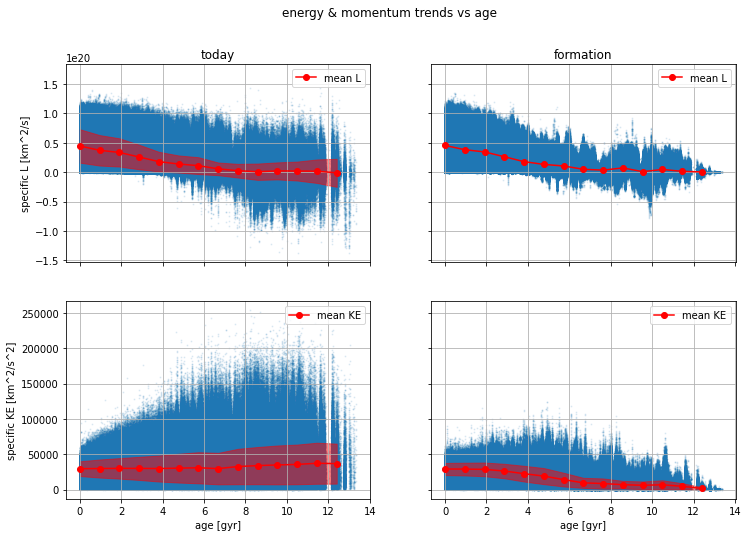

In [114]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey='row', sharex=True)
fig.suptitle('energy & momentum trends vs age')

axs[0,0] = plot_helper(age, L, 'mean L', ax=axs[0,0])
axs[0,0].set(ylabel = 'specific L [km^2/s]', title='today')

axs[0,1] = plot_helper(age, L_form, 'mean L', ax=axs[0,1])
axs[0,1].set(title='formation')

axs[1,0] = plot_helper(age, KE, 'mean KE', ax=axs[1,0])
axs[1,0].set(xlabel = 'age [gyr]', ylabel = 'specific KE [km^2/s^2]');

axs[1,1] = plot_helper(age, KE_form, 'mean KE', ax=axs[1,1])
axs[1,1].set(xlabel = 'age [gyr]');

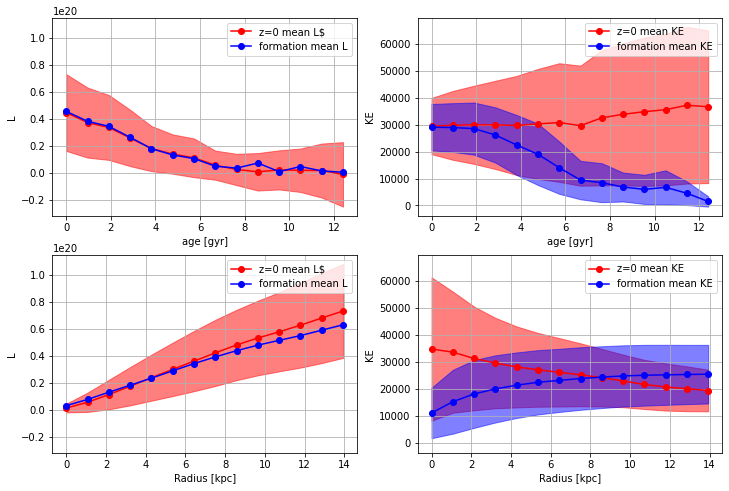

In [192]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharey='col')

axs[0,0] = plot_helper(age, L, 'z=0 mean L$', ax=axs[0,0], scatter=False, c='r')
axs[0,0] = plot_helper(age, L_form, 'formation mean L', ax=axs[0,0], scatter=False, c='b', grid=False)
axs[0,0].set(xlabel = 'age [gyr]', ylabel='L');

axs[0,1] = plot_helper(age, KE, 'z=0 mean KE', ax=axs[0,1], scatter=False, c='r')
axs[0,1] = plot_helper(age, KE_form, 'formation mean KE', ax=axs[0,1], scatter=False, c='b', grid=False)
axs[0,1].set(xlabel = 'age [gyr]', ylabel='KE');

axs[1,0] = plot_helper(R, L, 'z=0 mean L$', ax=axs[1,0], scatter=False, c='r')
axs[1,0] = plot_helper(R, L_form, 'formation mean L', ax=axs[1,0], scatter=False, c='b', grid=False)
axs[1,0].set(xlabel = 'Radius [kpc]', ylabel='L');

axs[1,1] = plot_helper(R, KE, 'z=0 mean KE', ax=axs[1,1], scatter=False, c='r')
axs[1,1] = plot_helper(R, KE_form, 'formation mean KE', ax=axs[1,1], scatter=False, c='b', grid=False)
axs[1,1].set(xlabel = 'Radius [kpc]', ylabel='KE');

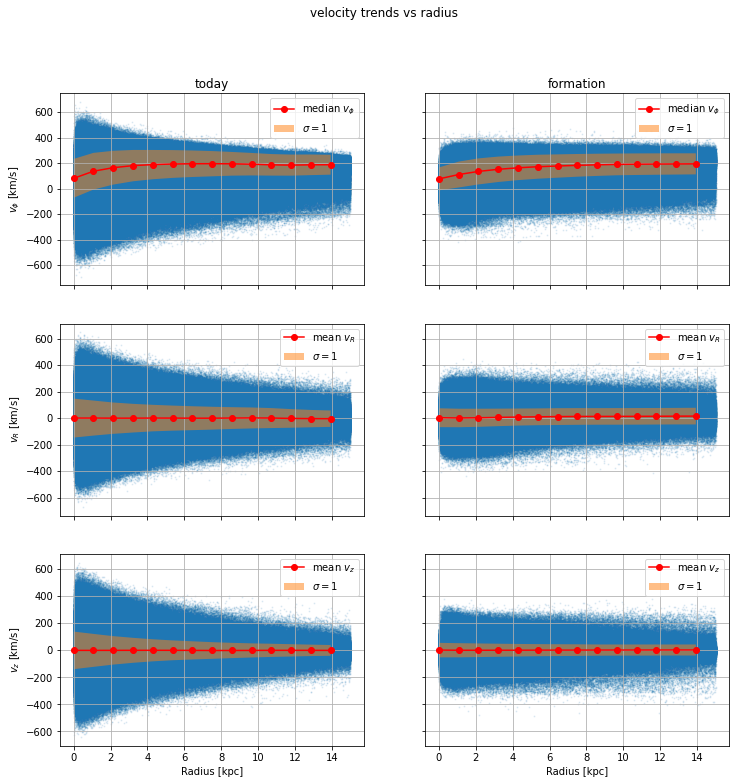

In [43]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharex='col', sharey='row')
fig.suptitle('velocity trends vs radius (z=0)')

axs[0,0] = plot_helper(R, v_phi, 'median $v_{\phi}$', ax=axs[0,0], stat='median')
axs[0,0].set(ylabel = '$v_{\phi}$ [km/s]', title='today')

axs[0,1] = plot_helper(R, v_phi_form, 'median $v_{\phi}$', ax=axs[0,1], stat='median')
axs[0,1].set(title='formation')

axs[1,0] = plot_helper(R, v_R, 'mean $v_R$', ax=axs[1,0])
axs[1,0].set(ylabel = '$v_R$ [km/s]');

axs[1,1] = plot_helper(R, v_R_form, 'mean $v_R$', ax=axs[1,1])

axs[2,0] = plot_helper(R, v_z, 'mean $v_z$', ax=axs[2,0])
axs[2,0].set(xlabel = 'Radius [kpc]', ylabel = '$v_z$ [km/s]');

axs[2,1] = plot_helper(R, v_z_form, 'mean $v_z$', ax=axs[2,1])
axs[2,1].set(xlabel = 'Radius [kpc]');

[Text(0.5, 0, 'Radius [kpc]')]

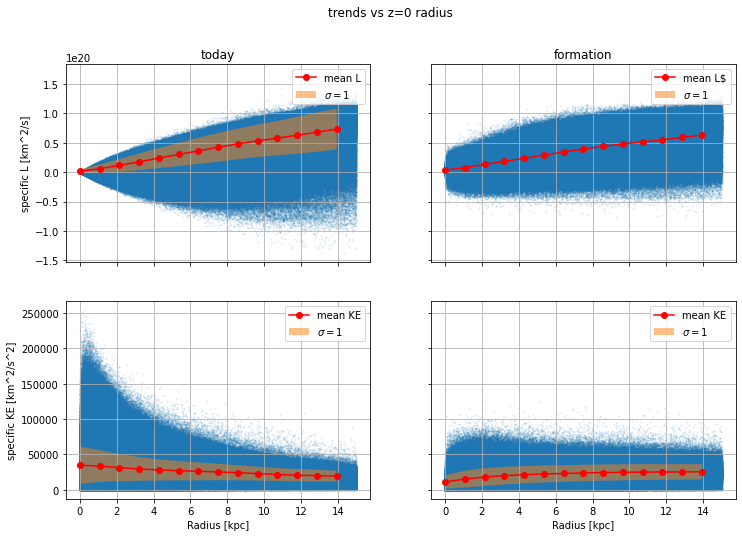

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey='row')
fig.suptitle('energy & momentum trends vs radius (z=0)')

axs[0,0] = plot_helper(R, L, 'mean L', ax=axs[0,0])
axs[0,0].set(ylabel = 'specific L [km^2/s]', title='today')

axs[0,1] = plot_helper(R, L_form, 'mean L$', ax=axs[0,1])
axs[0,1].set(title='formation')

axs[1,0] = plot_helper(R, KE, 'mean KE', ax=axs[1,0])
axs[1,0].set(xlabel = 'Radius [kpc]', ylabel = 'specific KE [km^2/s^2]');

axs[1,1] = plot_helper(R, KE_form, 'mean KE', ax=axs[1,1])
axs[1,1].set(xlabel = 'Radius [kpc]');

## specific angular momentum

$j = Rv_{\phi}$ for star particles at sun's current pos ($R=8 \pm 1$ kpc) today

In [64]:
R8_inds = ut.array.get_indices(R, [7,9])
R8_inds = ut.array.get_indices(R, [7,9], )

f_R8_inds = ut.array.get_indices(R_form, [7,9])

R8_ps = ps[R8_inds]
R8_vs = vs[R8_inds]
R8_age = age[R8_inds]

R8_ps_form = ps_form[R8_inds]
R8_vs_form = vs_form[R8_inds]

In [69]:
R8_j = R8_ps[::, 0]*R8_vs[::, 1]
R8_j_form = R8_ps_form[::, 0]*R8_vs_form[::, 1]

f_R8_j = ps[f_R8_inds][::, 0]*vs[f_R8_inds][::, 1]
f_R8_j_form = ps_form[f_R8_inds][::, 0]*vs_form[f_R8_inds][::, 1]

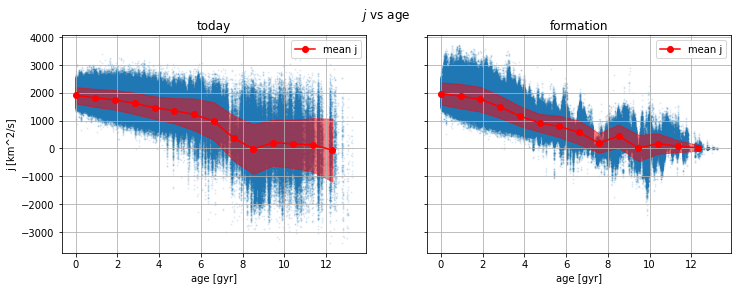

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle('$j$ vs age')

axs[0] = plot_helper(R8_age, R8_j, 'mean j', ax=axs[0])
axs[0].set(xlabel = 'age [gyr]', ylabel = 'j [km^2/s]', title='today')

axs[1] = plot_helper(R8_age, R8_j_form, 'mean j', ax=axs[1])
axs[1].set(xlabel = 'age [gyr]', title='formation');

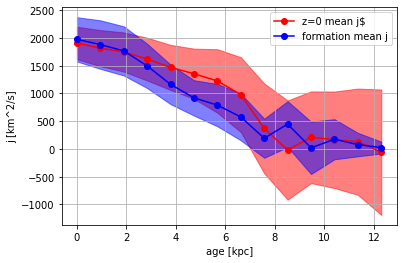

In [53]:
fig, ax = plt.subplots()

ax = plot_helper(R8_age, R8_j, 'z=0 mean j', ax=ax, scatter=False, c='r')
ax = plot_helper(R8_age, R8_j_form, 'formation mean j', ax=ax, scatter=False, c='b', grid=False)
ax.set(xlabel='age [kpc]', ylabel='j [km^2/s]');

In [70]:
R8_j_diff = R8_j-R8_j_form
f_R8_j_diff = f_R8_j-f_R8_j_form

In [91]:
print(np.mean(R8_j))

1359.3720957631008


In [123]:
def plot_hist_stats(data, ax=None, numstd=1):
    if ax==None:
        ax = plt.gca()
    mean = np.mean(data)
    std = np.std(data)
    c=['r', 'orange']
    ax.axvline(mean, c=c[0], label=f'mean = {mean:.3f}')
    for i in range(numstd):
        ax.axvline(mean-std*(i+1), c=c[i], linestyle='dashed', label=f'{i+1} $\sigma$ = {std*(i+1):.3f}')
        ax.axvline(mean+std*(i+1), linestyle='dashed', c=c[i])
    ax.legend()
    return ax

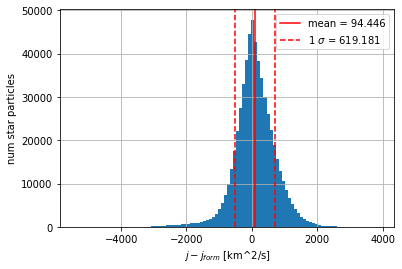

In [126]:
fig, ax = plt.subplots()

ax.hist(R8_j_diff, bins=100)
ax.set(xlabel='$j-j_{form}$ [km^2/s]', ylabel='num star particles')
ax = plot_hist_stats(R8_j_diff)
ax.grid();

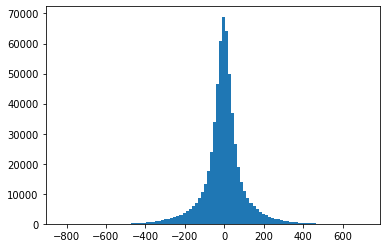

In [273]:
fig, ax = plt.subplots()
ax.hist(R8_vz_diff, bins=100);
# ax.set(xlabel='age [gyr]', ylabel = 'num star particles');

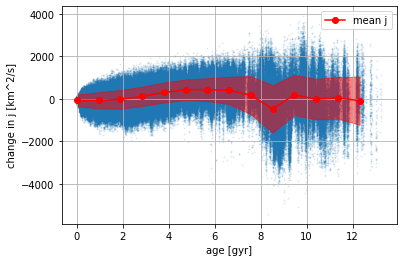

In [57]:
fig, ax = plt.subplots()

ax = plot_helper(R8_age, R8_j_diff, 'mean j', ax=ax)
ax.set(xlabel = 'age [gyr]', ylabel = 'change in j [km^2/s]');

In [71]:
R8_vz_diff = R8_vs[::, 2]-R8_vs_form[::, 2]
R8_vR_diff = R8_vs[::, 0]-R8_vs_form[::, 0]

f_R8_vz_diff = vs[f_R8_inds][::, 2]-vs_form[f_R8_inds][::, 2]
f_R8_vR_diff = vs[f_R8_inds][::, 0]-vs_form[f_R8_inds][::, 0]

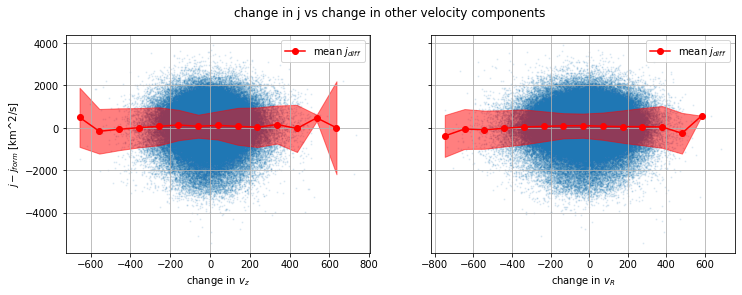

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle('change in j vs change in other velocity components')

axs[0] = plot_helper(R8_vz_diff, R8_j_diff, 'mean $j_{diff}$', ax=axs[0])
axs[0].set(xlabel = 'change in $v_z$', ylabel = '$j-j_{form}$ [km^2/s]')

axs[1] = plot_helper(R8_vR_diff, R8_j_diff, 'mean $j_{diff}$', ax=axs[1])
axs[1].set(xlabel = 'change in $v_R$');

In [135]:
def ratio_checker(v_circ_form, v_circ_diff, Rform=True, cutoff=0.2):
    inds = R8_inds
    if Rform:
        inds = f_R8_inds
    # indices of stars particles formed on circular orbits
    form_inds = ut.array.get_indices(ps_form[inds][::, 2], [-0.3, 0.3]) # |z| < 300 pc
    v_tot = np.sqrt(np.square(vs_form[inds][::, 0]) + np.square(vs_form[inds][::, 2]))
    form_inds = ut.array.get_indices(v_tot, [0,v_circ_form], form_inds)  # sqrt(vR^2 + vz^2) < 20 km/s

    vz_diff = vs[inds][::, 2]-vs_form[inds][::, 2]
    vR_diff = vs[inds][::, 0]-vs_form[inds][::, 0]
    
    j = ps[inds][::, 0]*vs[inds][::, 1]
    j_form = ps_form[inds][::, 0]*vs_form[inds][::, 1]
    j_diff = (j-j_form)/j_form
    
    # indices of orbits that stay circular: sum in quadrature of change < 10 km/s 
    v_tot_change = np.sqrt(np.square(vz_diff) + np.square(vR_diff))

    non_circular_inds = ut.array.get_indices(v_tot_change, [v_circ_diff, max(v_tot_change)], form_inds) 

    cold_T_inds = ut.array.get_indices(v_tot_change, [0, v_circ_diff], form_inds)
    
    cold_T_cutoff_inds = ut.array.get_indices(abs(j_diff), [cutoff, max(abs(j_diff))], cold_T_inds)
        
    return len(cold_T_cutoff_inds)/len(non_circular_inds), j_diff[cold_T_inds]

# v_circ_form = 5
# v_circ_diff = 10

# # indices of stars particles formed on circular orbits
# form_inds = ut.array.get_indices(R8_ps_form[::, 2], [-0.3, 0.3]) # |z| < 300 pc
# R8_v_tot = np.sqrt(np.square(R8_vs_form[::, 0]) + np.square(R8_vs_form[::, 2]))
# form_inds = ut.array.get_indices(R8_v_tot, [0,v_circ_form], form_inds)  # sqrt(vR^2 + vz^2) < 20 km/s

# # indices of orbits that stay circular: sum in quadrature of change < 10 km/s 
# R8_v_tot_change = np.sqrt(np.square(R8_vz_diff) + np.square(R8_vR_diff))

# non_circular_inds = ut.array.get_indices(R8_v_tot_change, [v_circ_diff, max(R8_v_tot_change)], form_inds) 

# cold_T_inds = ut.array.get_indices(R8_v_tot_change, [0, v_circ_diff], form_inds)

# cold_T_inds = ut.array.get_indices(abs(R8_j_diff), [500, max(abs(R8_j_diff))], cold_T_inds)

# len(cold_T_inds)/len(non_circular_inds)

In [180]:
print(f'mean R=8(at formation) vphi today: {np.mean(vs[f_R8_inds][::, 1])}')
print(f'mean R=8(at formation) vphi at formation: {np.mean(vs_form[f_R8_inds][::, 1])}')

print(f'mean tot vphi today: {np.mean(vs[::, 1])}')
print(f'mean tot vphi at formation: {np.mean(vs_form[::, 1])}')

mean R=8(at formation) vphi today: 158.8684844970703
mean R=8(at formation) vphi at formation: 165.8130340576172
mean tot vphi today: 126.4609146118164
mean tot vphi at formation: 128.0930633544922


In [186]:
ratio, c_T_dist = ratio_checker(16, 16, Rform=False, cutoff=0.2)
print(ratio)

0.031586408541177516


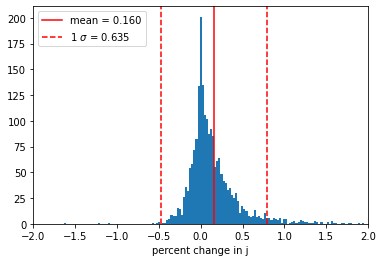

In [187]:
fig, ax = plt.subplots()

ax.hist(c_T_dist, bins=1000);
ax = plot_hist_stats(c_T_dist, numstd=1)
ax.set(xlabel='percent change in j', xlim=[-2,2]);

v_form = non-rotational velocity components at formation
v_change = change in non-rotational velocity components (sqrt(vR^2 + vz^2))

mean vphi around R=8 is approx 160 km/s, so 10% is 16 km/s

In [188]:
vcirc_change_range = np.linspace(0, 30)
R_ratio, Rform_ratio = [], []
for i in range(len(vcirc_change_range)):
    ratio, c_T_dist = ratio_checker(16, vcirc_change_range[i], Rform=False, cutoff=0.2)
    R_ratio += [ratio]
    ratio, c_T_dist = ratio_checker(16, vcirc_change_range[i], cutoff=0.2)
    Rform_ratio += [ratio]

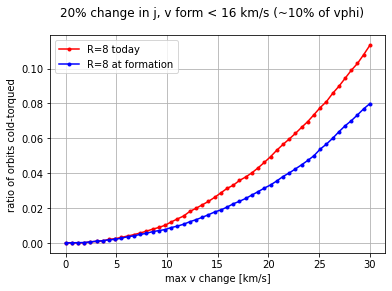

In [189]:
fig, ax = plt.subplots()
fig.suptitle('20% change in j, v form < 16 km/s (~10% of vphi)')
ax.plot(vcirc_change_range, R_ratio, 'r.-', label='R=8 today')
ax.plot(vcirc_change_range, Rform_ratio, '.-', c='b', label='R=8 at formation')
ax.legend()
ax.grid()
ax.set(xlabel='max v change [km/s]', ylabel='ratio of orbits cold-torqued');

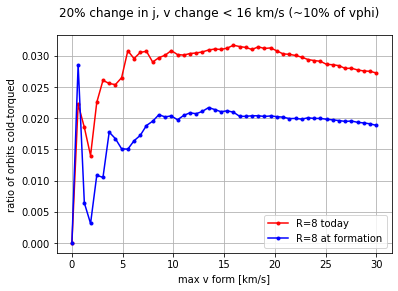

In [190]:
vcirc_form_range = np.linspace(0, 30)
R_ratio, Rform_ratio = [], []
for i in range(len(vcirc_form_range)):
    if vcirc_form_range[i]==0:
        R_ratio += [0]
        Rform_ratio += [0]
    else:
        ratio, c_T_dist = ratio_checker(vcirc_form_range[i], 16, Rform=False, cutoff=0.2)
        R_ratio += [ratio]
        ratio, c_T_dist = ratio_checker(vcirc_form_range[i], 16, cutoff=0.2)
        Rform_ratio += [ratio]
    
fig, ax = plt.subplots()
fig.suptitle('20% change in j, v change < 16 km/s (~10% of vphi)')
ax.plot(vcirc_form_range, R_ratio, 'r.-', label='R=8 today')
ax.plot(vcirc_form_range, Rform_ratio, '.-', c='b', label='R=8 at formation')
ax.legend()
ax.grid()
ax.set(xlabel='max v form [km/s]', ylabel='ratio of orbits cold-torqued');

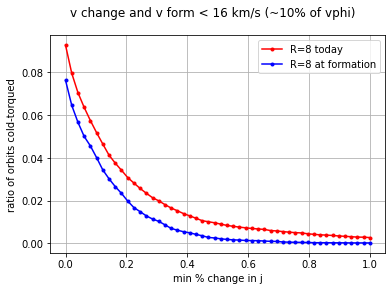

In [191]:
t_cutoff_range = np.linspace(0, 1)
R_ratio, Rform_ratio = [], []
for i in range(len(t_cutoff_range)):
    ratio, c_T_dist = ratio_checker(16, 16, Rform=False, cutoff=t_cutoff_range[i])
    R_ratio += [ratio]
    ratio, c_T_dist = ratio_checker(16, 16, cutoff=t_cutoff_range[i])
    Rform_ratio += [ratio]
    
fig, ax = plt.subplots()
fig.suptitle('v change and v form < 16 km/s (~10% of vphi)')
ax.plot(t_cutoff_range, R_ratio, 'r.-', label='R=8 today')
ax.plot(t_cutoff_range, Rform_ratio, 'b.-', label='R=8 at formation')
ax.legend()
ax.grid()
ax.set(xlabel='min % change in j', ylabel='ratio of orbits cold-torqued');

In [147]:
help(ut.array.get_indices)

Help on function get_indices in module utilities.array:

get_indices(values, limits=[-inf, inf], prior_indices=None, get_masks=False, dtype=None, verbose=True)
    Get the indices of the input values array that are within the input limits
    [>= min(limits), < max(limits)),
    that also are in the input prior_indices array (if defined).
    
    Either entry in input limits can be of same size as input values array if want to select each
    value with a different limit.
    
    Parameters
    ----------
    values : array
        array of values to get indices of
    limits : list
        limits to use to select values, within range [min(limits), max(limits))
    prior_indices : array
        indices of input value array to select on first (before imposing limits)
    get_masks : bool
        whether to return selection indices of input indices array
    dtype
        data type for array of indices
    verbose : bool
        whether to print warnings
    
    Returns
    -------
  